In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
experiments = ['20210601', '20210629', '20210720', '20210810']

In [37]:
experiments_table = pd.DataFrame(columns = ['Drug', 'PCR', 'Cholesterol', 'Experiment'])
data = {}
for exp in experiments:
    print(exp)
    
    data[exp] = pd.read_excel('../data/ddPCR_koleszterinvsSARSvsDrug.xlsx', sheet_name = exp)
    # delete co-administration data
    idx = data[exp].where(data[exp]=='Co-administration').dropna(how = 'all').index

    if len(idx) > 0:
        data[exp] = data[exp][:idx[0]]
    
    # drop all NaN values and fill drug values
    data[exp] = data[exp].dropna(how = 'all').fillna(method = 'ffill', axis = 0).dropna(axis = 1, how = 'all')
    data[exp].columns = data[exp].iloc[0]
    data[exp] = data[exp].iloc[1:, :6]

    data[exp].columns = [ '0um_chol', '0um_chol_PCR', '80um_chol',
                 '80um_chol_PCR', '10um_chol', '10um_chol_PCR']
    
    # append data to experiments_table
    for cc in [0, 80, 10]:
        tmp = data[exp][[str(cc)+'um_chol', str(cc)+'um_chol_PCR']]
        tmp['Cholesterol'] = str(cc)+'um'
        tmp['Experiment'] = exp
        tmp.columns = experiments_table.columns
        
        experiments_table = experiments_table.append(tmp, ignore_index = True)
    experiments_table = experiments_table.drop_duplicates()
    

20210601
20210629
20210720
20210810


In [38]:
experiments_table = experiments_table.replace('Pozitív ctrl', 'Control')
experiments_table = experiments_table.replace('DMSO ', 'DMSO')
experiments_table = experiments_table.replace('Chlorpromazine ', 'Chlorpromazine')
experiments_table = experiments_table.replace('Amiodarone (DMSO)', 'Amiodarone')

experiments_table.PCR = experiments_table.PCR.apply(lambda x: float(str(x).replace(',', '.')))

In [52]:
toplot = experiments_table[experiments_table.Drug.isin(['Control', 'Chlorpromazine',
                                                        'Amiodarone', 'Loperamide']) & 
                          experiments_table.Cholesterol.isin(['0um', '80um'])]


In [53]:
toplot = toplot.replace('0um', 'No cholesterol')
toplot = toplot.replace('80um', '80 \u03BCM cholesterol')

In [54]:
toplot.PCR = np.log2(toplot.PCR)
toplot["Drug"] = pd.Categorical(toplot["Drug"],
                                categories = ["Control", "Amiodarone", "Chlorpromazine", "Loperamide"])

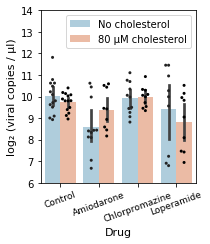

In [89]:
fig, ax = plt.subplots(figsize = (3,3.5))
g = sns.barplot(x = 'Drug', y = 'PCR', hue = 'Cholesterol', data=toplot, palette = 'RdBu_r')
g = sns.swarmplot(x = 'Drug', y = 'PCR', hue = 'Cholesterol', 
                  data=toplot, dodge=True, color = 'k', size = 3)

handles, labels = g.get_legend_handles_labels()
g.legend(handles[2:], labels[2:])

plt.ylim((6,14))
plt.xticks(rotation = 20, ha="center", fontsize = 9)
plt.xlabel('Drug', fontsize = 11)
plt.ylabel('log\u2082 (viral copies / \u03BCl)', fontsize = 11)
plt.tight_layout()
plt.savefig('../figures/draft/Fig5B.pdf')
plt.show()